# Data augmentation for a CNN predicting CelebA dataset

The CelebA dataset contains $202599$ images of celebrities’ faces. In addition, $40$ binary facial attributes are available for each image, including whether a celebrity is smiling (or not). We will build and train a CNN model for predicting the smile attribute of these images. However, we will only use $16000$ training examples and focus on using data augmentation to improve the generalization performance.

We will load the CelebA dataset using `torchvision`, which already provides the dataset in three partitions: a training set, a validation set, and a test set.

In [1]:
import torch
import torchvision

#load CelebA dataset
img_path = './'
celeba_train = torchvision.datasets.CelebA(img_path, split='train', target_type='attr', download=True)
celeba_valid = torchvision.datasets.CelebA(img_path, split='valid', target_type='attr', download=True)
celeba_test = torchvision.datasets.CelebA(img_path, split='test', target_type='attr', download=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### Data preprocessing

There are multiple transformations available for images in the `torchvision.transforms` module. Below, we will visualize five of these transformations, namely:
 - cropping an image to a bounding box
 - flipping an image horizontally
 - adjusting the contrast
 - adjusting the brightness
 - center-cropping an image and resizing the resulting image back to its original size

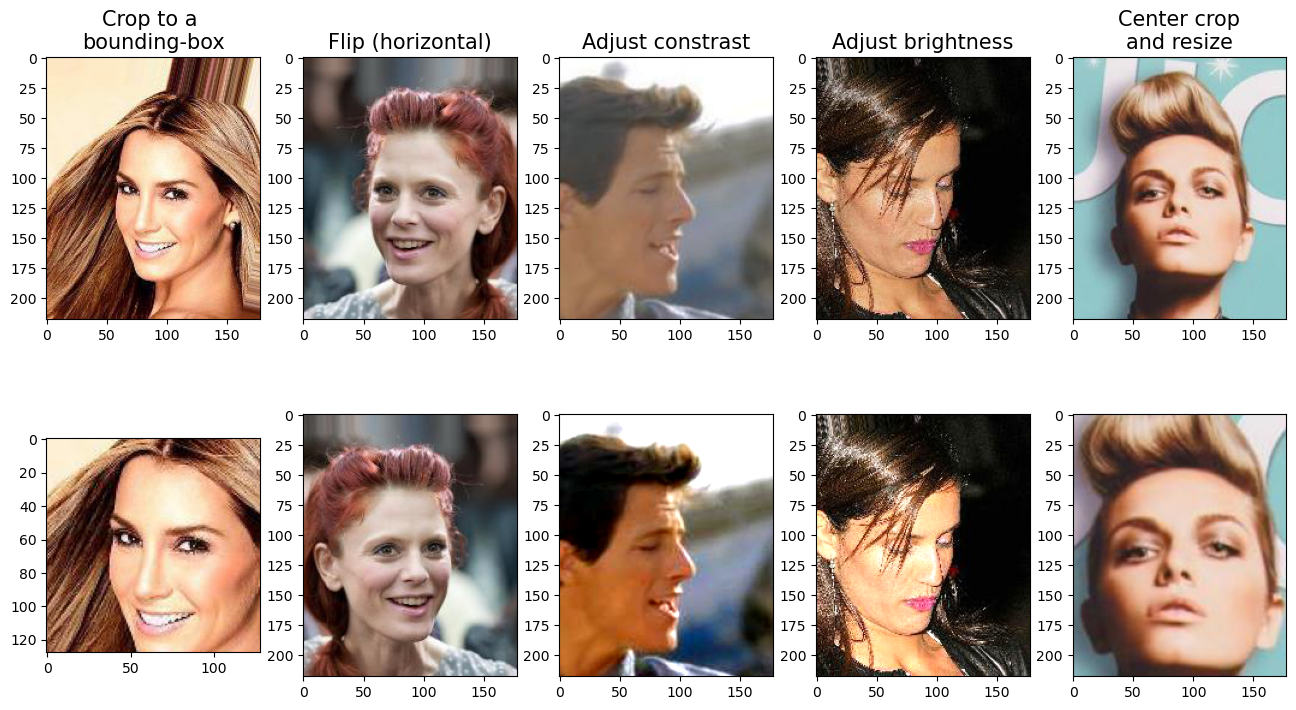

In [4]:
from torchvision import transforms
import matplotlib.pyplot as plt

#set up figures
fig = plt.figure(figsize=(16, 8.5))

#ex 1: cropping to a bounding-box
ax = fig.add_subplot(2, 5, 1)
img, attr = celeba_train[0]
ax.set_title('Crop to a \nbounding-box', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 6)
img_cropped = transforms.functional.crop(img, 50, 20, 128, 128) 
ax.imshow(img_cropped)

#ex 2: flipping (horizontally)
ax = fig.add_subplot(2, 5, 2)
img, attr = celeba_train[1]
ax.set_title('Flip (horizontal)', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 7)
img_flipped = transforms.functional.hflip(img)
ax.imshow(img_flipped)

#ex 3: adjust contrast
ax = fig.add_subplot(2, 5, 3)
img, attr = celeba_train[2]
ax.set_title('Adjust constrast', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 8)
img_adj_contrast = transforms.functional.adjust_contrast(img, contrast_factor=2)
ax.imshow(img_adj_contrast)

#ex 4: adjust brightness
ax = fig.add_subplot(2, 5, 4)
img, attr = celeba_train[3]
ax.set_title('Adjust brightness', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 9)
img_adj_brightness = transforms.functional.adjust_brightness(img, brightness_factor=1.3)
ax.imshow(img_adj_brightness)

#ex 5: cropping from image center
ax = fig.add_subplot(2, 5, 5)
img, attr = celeba_train[4]
ax.set_title('Center crop\nand resize', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 10)
img_center_crop = transforms.functional.center_crop(img, [0.7*218, 0.7*178])
img_resized = transforms.functional.resize(img_center_crop, size=(218, 178))
ax.imshow(img_resized)

#display figures
plt.show()

While the transformations above are deterministic, they can all be randomized, which is preferable for data augmentation during training. For example, we can crop a random bounding box from an image, or we can uniformly select the `contrast_factor` at random that determines the contrast of an image. We will define a `transform_train` function that will produce a randomly transformed image, first by randomly cropping it, then randomly flipping it, before resizing the image to the desired size of $64\times 64$ pixels. We then define a deterministic function that we apply to the validation and test sets to center-crop the images and resize them to the desired $64\times 64$ size.

In [5]:
#define random transformation for training images
transform_train = transforms.Compose([
    transforms.RandomCrop([178, 178]),
    transforms.RandomHorizontalFlip(),
    transforms.Resize([64, 64]),
    transforms.ToTensor(),])

#define deterministic transformation for validation and test images
transform = transforms.Compose([
    transforms.CenterCrop([178, 178]),
    transforms.Resize([64, 64]),
    transforms.ToTensor(),])

Now, we create a `DataLoader` object to iterate over the training dataset five times and apply the `transform_train` function to each image. We will visualize the random transformations applied to two example images.

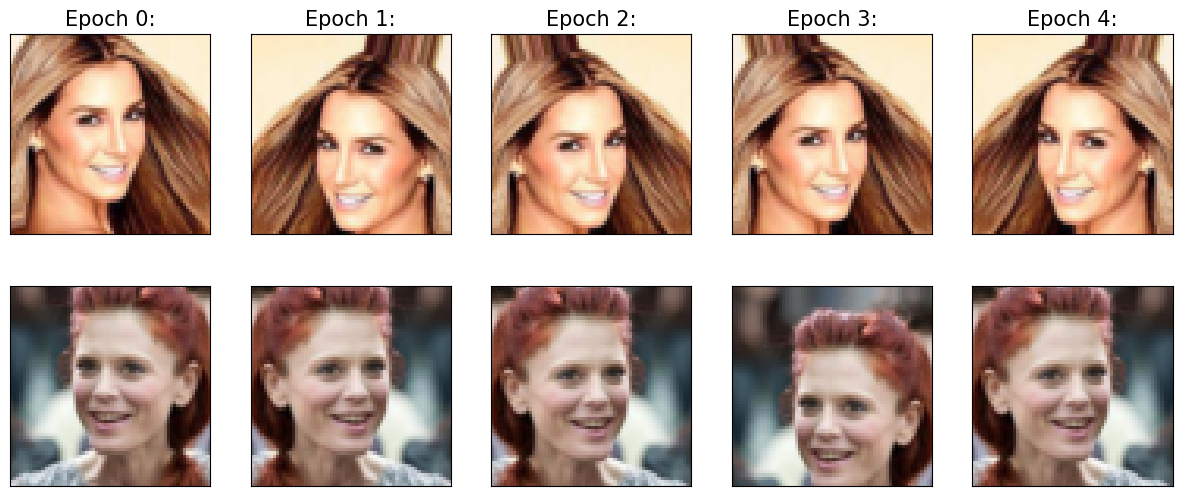

In [9]:
from torch.utils.data import DataLoader

#define lambda to retrieve smile attribute
get_smile = lambda attr: attr[31]

#load training images with random transformation applied
celeba_train = torchvision.datasets.CelebA(img_path, split='train',
                                           target_type='attr', download=False, 
                                           transform=transform_train, target_transform=get_smile)

#create DataLoader to iterate over training set
torch.manual_seed(1) #seed for reproducibility
transform_dl = DataLoader(celeba_train, batch_size=2)

#iterate over training set and display some randomly transformed example images
fig = plt.figure(figsize=(15, 6))
num_epochs = 5
for j in range(num_epochs):
    img_batch, label_batch = next(iter(transform_dl))
    
    #example image 1
    img = img_batch[0]
    ax = fig.add_subplot(2, 5, j + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Epoch {j}:', size=15)
    ax.imshow(img.permute(1, 2, 0))
    
    #example image 2
    img = img_batch[1]
    ax = fig.add_subplot(2, 5, j + 6)
    ax.set_xticks([]), ax.set_yticks([])
    ax.imshow(img.permute(1, 2, 0))

#display example images
plt.show()

Next, we apply the deterministic `transform` function to the validation and test sets.

In [10]:
#load in transformed validation images
celeba_valid = torchvision.datasets.CelebA(img_path, split='valid', 
                                           target_type='attr', download=False, 
                                           transform=transform, target_transform=get_smile)

#load in transformed test images
celeba_test = torchvision.datasets.CelebA(img_path, split='test', 
                                          target_type='attr', download=False, 
                                          transform=transform, target_transform=get_smile)

Instead of using the entire training and validation sets, we will instead use a subset of $16000$ training examples and $1000$ validation examples, as we want to intentionally train our model with a small, but augmented dataset. We then create `DataLoader` objects for each of the training, validation, and test sets.

In [17]:
from torch.utils.data import Subset

#create subsets of training and validation data
celeba_train = Subset(celeba_train, torch.arange(16000))
celeba_valid = Subset(celeba_valid, torch.arange(1000))

#create DataLoader objects with batch size 32 for training, validation, and test sets
batch_size = 32
torch.manual_seed(1) #for reproducibility
train_dl = DataLoader(celeba_train, batch_size, shuffle=True)
valid_dl = DataLoader(celeba_valid, batch_size, shuffle=False)
test_dl = DataLoader(celeba_test, batch_size, shuffle=False)

### Training a CNN classifier

The CNN model receives input images of size $3\times 64\times 64$, where we have $3$ color channels. We put the input images through four convolutional layers, producing $32$, $64$, $128$, and $256$ feature maps, respectively using filters with kernel size $3\times 3$ and padding size $1$. We follow the first three convolutional layers with a max-pooling layer with kernel size $2\times 2$, and the first two of these max-pooling layers are followed by a dropout layer with probability $0.5$ for regularization.

In [14]:
import torch.nn as nn

#define feature extraction layers of CNN architecture
model = nn.Sequential()

#1st convolutional layer: ReLU activation, max-pooling, then dropout
model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))
model.add_module('dropout1', nn.Dropout(p=0.5))

#2nd convolutional layer: ReLU activation, max-pooling, then dropout
model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))
model.add_module('dropout2', nn.Dropout(p=0.5))

#3rd convolutional layer: ReLU activation, max-pooling
model.add_module('conv3', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1))
model.add_module('relu3', nn.ReLU())
model.add_module('pool3', nn.MaxPool2d(kernel_size=2))

#4th convolutional layer: ReLU activation
model.add_module('conv4', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1))
model.add_module('relu4', nn.ReLU())

Now, we will add a global average-pooling layer which computes the average of each feature map separately, which will reduce the number of hidden units to $256$. Afterwards, we flatten the output and add a single fully-connected layer with $256$ nodes that maps to a single output node, to which we apply the sigmoid activation function to predict the probability that the image contains a smiling celebrity.

In [16]:
#global average-pooling layer
model.add_module('pool4', nn.AvgPool2d(kernel_size=8))

#flatten and add fully connected layer with sigmoid activation
model.add_module('flatten', nn.Flatten())
model.add_module('fc', nn.Linear(256, 1))
model.add_module('sigmoid', nn.Sigmoid())

#display model architecture
model

Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (pool4): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

We define a binary cross-entropy loss function and choose to employ the Adam optimizer, then we define the training function for the CNN.

In [18]:
#define binary cross-entropy loss function
loss_fn = nn.BCELoss()

#define Adam optimizer with learning rate 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#define train function
def train(model, num_epochs, train_dl, valid_dl):
    #track training and validation loss and accuracy
    loss_hist_train = [0] * num_epochs
    acc_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    acc_hist_valid = [0] * num_epochs
    
    #training loop
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            #generate predictions
            pred = model(x_batch)[:, 0]
            
            #calculate loss
            loss = loss_fn(pred, y_batch.float())
            
            #compute gradients
            loss.backward()
            
            #update parameters using gradients
            optimizer.step()
            
            #reset the gradients to zero
            optimizer.zero_grad()
            
            #add up the training loss and accuracy for each batch
            loss_hist_train[epoch] += loss.item() * y_batch.size(0)
            is_acc = ((pred>=0.5).float() == y_batch).float()
            acc_hist_train[epoch] += is_acc.sum()
            
        loss_hist_train[epoch] /= len(train_dl.dataset)
        acc_hist_train[epoch] /= len(train_dl.dataset)
        
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                #generate predictions
                pred = model(x_batch)[:, 0]
            
                #calculate loss
                loss = loss_fn(pred, y_batch.float())

                #add up the validation loss and accuracy for each batch
                loss_hist_valid[epoch] += loss.item() * y_batch.size(0)
                is_acc = ((pred>=0.5).float() == y_batch).float()
                acc_hist_valid[epoch] += is_acc.sum()
                
        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        acc_hist_valid[epoch] /= len(valid_dl.dataset)
        
        print(f'Epoch {epoch+1} accuracy: '
              f'{acc_hist_train[epoch]:.4f} val_accuracy: '
              f'{acc_hist_valid[epoch]:.4f}')
    
    return loss_hist_train, loss_hist_valid, acc_hist_train, acc_hist_valid

Next, we train the CNN for $30$ epochs and verbosely track the training progress.

In [19]:
#train the CNN for 30 epochs
torch.manual_seed(1) #for reproducibility
num_epochs = 30
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.5127 val_accuracy: 0.5140
Epoch 2 accuracy: 0.5350 val_accuracy: 0.5500
Epoch 3 accuracy: 0.5655 val_accuracy: 0.5760
Epoch 4 accuracy: 0.6082 val_accuracy: 0.6000
Epoch 5 accuracy: 0.6264 val_accuracy: 0.6310
Epoch 6 accuracy: 0.6437 val_accuracy: 0.6350
Epoch 7 accuracy: 0.6518 val_accuracy: 0.6420
Epoch 8 accuracy: 0.6654 val_accuracy: 0.6680
Epoch 9 accuracy: 0.6708 val_accuracy: 0.6370
Epoch 10 accuracy: 0.6786 val_accuracy: 0.6770
Epoch 11 accuracy: 0.6900 val_accuracy: 0.6940
Epoch 12 accuracy: 0.7014 val_accuracy: 0.6980
Epoch 13 accuracy: 0.7157 val_accuracy: 0.7670
Epoch 14 accuracy: 0.7311 val_accuracy: 0.7310
Epoch 15 accuracy: 0.7576 val_accuracy: 0.8030
Epoch 16 accuracy: 0.7764 val_accuracy: 0.8050
Epoch 17 accuracy: 0.7927 val_accuracy: 0.8110
Epoch 18 accuracy: 0.8043 val_accuracy: 0.8240
Epoch 19 accuracy: 0.8179 val_accuracy: 0.8500
Epoch 20 accuracy: 0.8224 val_accuracy: 0.8730
Epoch 21 accuracy: 0.8299 val_accuracy: 0.8790
Epoch 22 accuracy: 0.8

We plot the learning curves for the training process to see how the model performed.

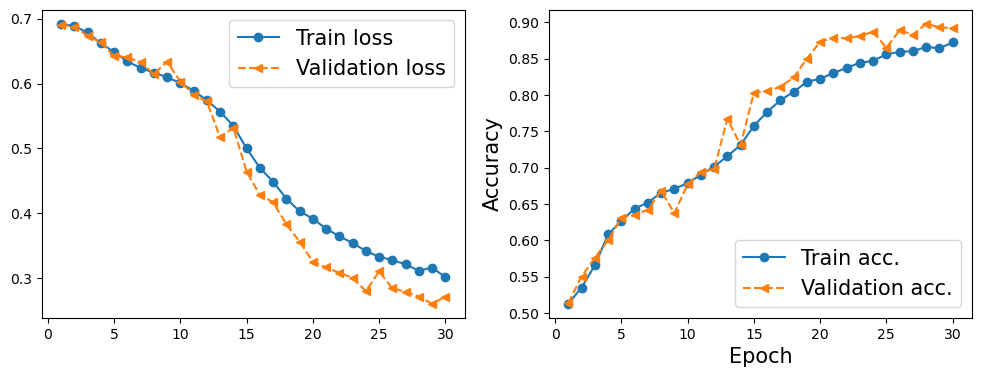

In [20]:
import matplotlib.pyplot as plt
import numpy as np

#set up x-axis
x = np.arange(len(hist[0])) + 1

#set up plots
fig = plt.figure(figsize=(12, 4))

#create plot of training and validation loss
ax = fig.add_subplot(1, 2, 1)
ax.plot(x, hist[0], '-o', label='Train loss')
ax.plot(x, hist[1], '--<', label='Validation loss')
ax.legend(fontsize=15)

#create plot of training and validation accuracy
ax = fig.add_subplot(1, 2, 2)
ax.plot(x, hist[2], '-o', label='Train acc.')
ax.plot(x, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

The learning curves are indicative of a successful training process. Not only does the loss steadily decrease and the accuracy steadily increase, but the validation accuracy is consistently close to or aove the training accuracy, which means that the model is not overfitting to the training set. This suggests that our strategy of data augmentation was successful.

Now, we see how our model performs on the test set.

In [21]:
acc_test = 0
model.eval()
with torch.no_grad():
    for x_batch, y_batch in test_dl:
        pred = model(x_batch)[:, 0]
        is_acc = ((pred>=0.5).float() == y_batch).float()
        acc_test += is_acc.sum()
acc_test /= len(test_dl.dataset)
print(f'Test accuracy: {acc_test:.4f}')

Test accuracy: 0.8914


We observe that the model achieved a classification accuracy of $89\%$ on the test set.

Finally, we visualize the model's predictions on the last batch of the pre-processed dataset and compare these predictions to the ground-truth labels.

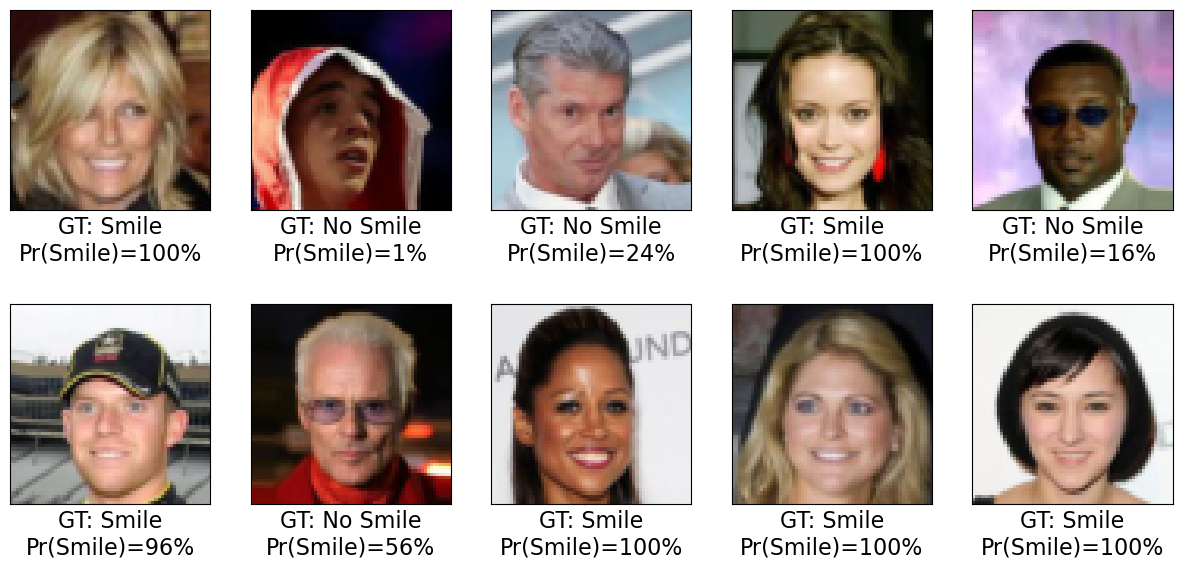

In [23]:
#compute probabilities of each image containing a smiling celebrity
pred = model(x_batch)[:, 0] * 100

#set up figure of images
fig = plt.figure(figsize=(15, 7))
for j in range(10, 20):
    ax = fig.add_subplot(2, 5, j-10+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(x_batch[j].permute(1, 2, 0))
    if y_batch[j] == 1:
        label='Smile'
    else:
        label = 'No Smile'
    ax.text(0.5, -0.15, f'GT: {label:s}\nPr(Smile)={pred[j]:.0f}%',
            size=16, horizontalalignment='center', verticalalignment='center',
            transform=ax.transAxes)

#display images
plt.show()